In [2]:
# https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351 참고
import tensorflow as tf
import numpy as np


from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
from keras import layers

from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, Sequential

import pathlib

# 로컬 데이터 경로 설정
data_dir = pathlib.Path("./dataset/")

height,width=180,180
training_batch_size=32

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    labels="inferred",
    seed=123,
    image_size=(height,width),
    batch_size=training_batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    labels="inferred",
    seed=123,
    image_size=(height,width),
    batch_size=training_batch_size
)

class_names = train_ds.class_names
print(class_names)

Found 20724 files belonging to 14 classes.
Using 16580 files for training.
Found 20724 files belonging to 14 classes.
Using 4144 files for validation.
['Corn___Common_rust', 'Corn___Gray_leaf_spot', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']


In [9]:
dnn_model = Sequential()

model= ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',
    classes=14,
    weights='imagenet')

for layer in model.layers:
    layer.trainable=False

In [10]:
dnn_model.add(model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(14, activation='softmax'))

In [11]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 14)                7182      
                                                                 
Total params: 24643982 (94.01 MB)
Trainable params: 1056270 (4.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [14]:
dnn_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
epochs=10
history = dnn_model.fit(
    train_ds, 
    validation_data=validation_ds, 
    epochs=epochs
)

Epoch 1/10
519/519 [==============================] - 354s 683ms/step - loss: 0.0321 - accuracy: 0.9887 - val_loss: 0.1039 - val_accuracy: 0.9677
Epoch 2/10
519/519 [==============================] - 438s 844ms/step - loss: 0.0347 - accuracy: 0.9869 - val_loss: 0.1064 - val_accuracy: 0.9694
Epoch 3/10
519/519 [==============================] - 348s 672ms/step - loss: 0.0338 - accuracy: 0.9890 - val_loss: 0.0954 - val_accuracy: 0.9732
Epoch 4/10
519/519 [==============================] - 381s 735ms/step - loss: 0.0318 - accuracy: 0.9885 - val_loss: 0.0880 - val_accuracy: 0.9735
Epoch 5/10
519/519 [==============================] - 385s 743ms/step - loss: 0.0181 - accuracy: 0.9939 - val_loss: 0.1234 - val_accuracy: 0.9691
Epoch 6/10
519/519 [==============================] - 512s 988ms/step - loss: 0.0272 - accuracy: 0.9903 - val_loss: 0.1217 - val_accuracy: 0.9679
Epoch 7/10
519/519 [==============================] - 446s 860ms/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 0.1691 -

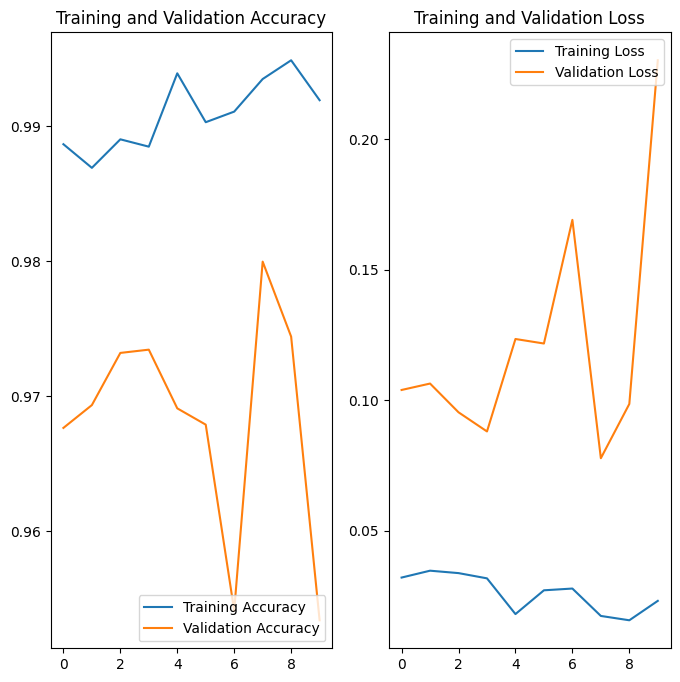

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
from keras.preprocessing import image
# 로컬 이미지 경로 설정
local_image_path = "./test-case/healthy_tomato.png"

# 이미지 불러오기
img = image.load_img(local_image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

# 모델 예측
predictions = dnn_model.predict(img_array)


# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

1/1 [==============================] - 0s 52ms/step
['Corn___Common_rust', 'Corn___Gray_leaf_spot', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']
[1.02329811e-10 1.04441234e-07 2.49312210e-10 3.12242210e-09
 8.40425021e-11 7.73197532e-13 6.64888438e-17 3.13327511e-12
 2.49778982e-11 3.39965510e-07 1.00000000e+02 9.71683064e-12
 9.00808508e-12 1.49481611e-15]
This image most likely belongs to Tomato___Late_blight with a 100.00 percent confidence.
